In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.constraints import max_norm
from PIL import Image


Using TensorFlow backend.


In [59]:
#path = '/home/grads/n/narendra5/Desktop/Programs/LER_machine_learning/'
path = r"C:\\Users\\narendra\\Documents\\LER\\LER_machine_learning\\"
model = load_model(path + r'models\\' + 'full_run1_epoch_4.h5')

#model = load_model(path + 'models/' + 'nnet_test_run_4.h5')

sigma = 1.2
alpha = 0.9
Xi = 10
width = 20
space = 20
noise = 3
shift = math.floor(-25 + (width + space/2 + Xi + alpha*10 + sigma*10)%16) 


original_file = path + 'original_images\\oim_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '.tiff'
noisy_file = path + 'noisy_images\\nim_' + "{0:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '_' + str(-shift) + '_' + str(noise) + '.tiff'

im = np.array(Image.open(original_file))
imnoisy = np.array(Image.open(noisy_file))

im = im/256
imnoisy = (imnoisy)/256
imnoisy = imnoisy.reshape(1,1024,64,1)
impredict = model.predict(imnoisy)

imnoisy = imnoisy.reshape(1024,64)
impredict = impredict.reshape(1024,64)
impredict = impredict.astype(float)
"""
impredict = np.around(impredict*256)
im = np.around(im*256)
imnoisy = np.around(imnoisy*256)
"""

mse = ((im - impredict) ** 2).mean()
print(mse)

snr_predict = (im**2).mean() / mse
snr_predict_dB = 10 * math.log(snr_predict)

snr_noise = ((im**2).mean()) / (((im - imnoisy) ** 2).mean()) 
snr_noise_dB = 10 * math.log(snr_noise)

print(snr_predict_dB, snr_noise_dB, snr_predict_dB - snr_noise_dB)

del model

0.00259714467825
34.68298654429407 2.0597952842678486 32.62319126002622


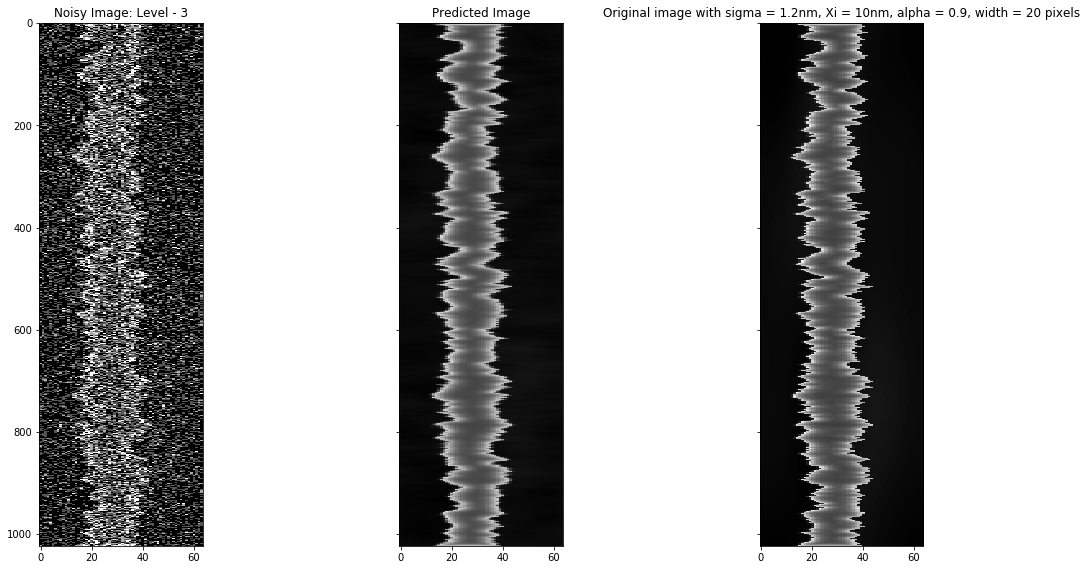

0.828125 0.125
0.80624371767 0.120765864849
0.99609375 0.0


In [60]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})


ax[0].imshow(imnoisy,cmap = 'gray',aspect= 0.2)
ax[0].set_title('Noisy Image: Level - {}'.format(noise))

ax[1].imshow(impredict, cmap = 'gray', aspect= 0.2)
ax[1].set_title('Predicted Image')

ax[2].imshow(im,cmap = 'gray',aspect = 0.2)
ax[2].set_title('Original image with sigma = {}nm, Xi = {}nm, alpha = {}, width = {} pixels'.format(sigma, Xi, alpha, width))
fig.tight_layout()
plt.show()

print(np.max(im), np.min(im))
print(np.max(impredict), np.min(impredict))
print(np.max(imnoisy), np.min(imnoisy))

PSNR noisy image = 11.68696661972422, PSNR predicted image = 25.855038566028
MSE noisy image = 0.06781149795278907, MSE predicted image = 0.002597144678249409
Estimated Gaussian noise standard deviation = 0.23568220669435783


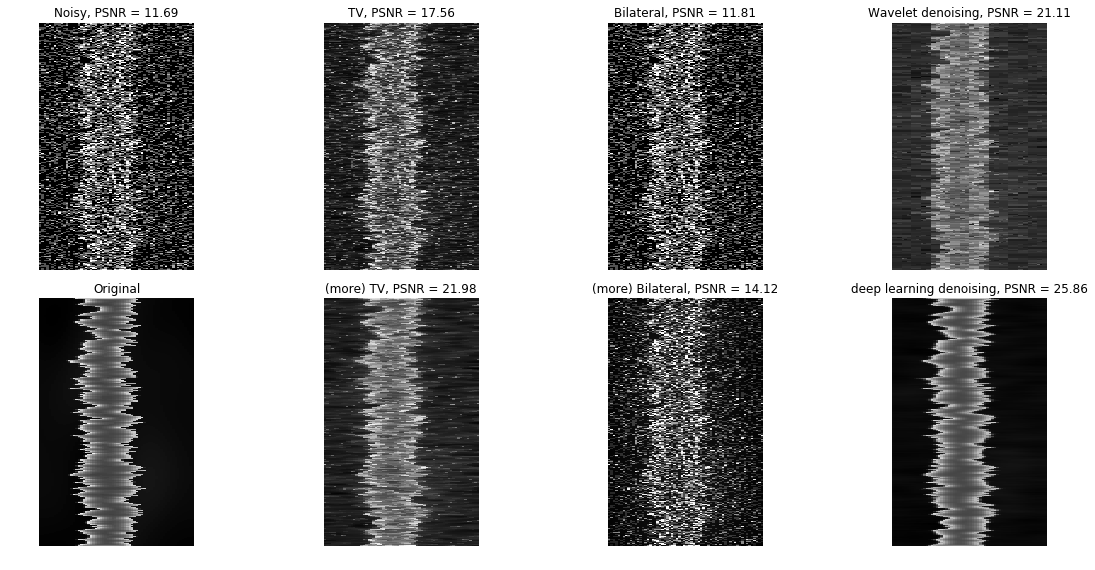

In [61]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import measure

#impredict = impredict.astype(float)
#imnoisy = imnoisy.astype(float)
#im = im.astype(float)

psnr_noisy = measure.compare_psnr(im,imnoisy)
psnr_predict = measure.compare_psnr(im,impredict)
mse_noisy = measure.compare_mse(im, imnoisy)
mse_predict = measure.compare_mse(im, impredict)

print('PSNR noisy image = {}, PSNR predicted image = {}'.format(psnr_noisy,psnr_predict))
print('MSE noisy image = {}, MSE predicted image = {}'.format(mse_noisy,mse_predict))


# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(imnoisy, multichannel=False, average_sigmas=True)

print("Estimated Gaussian noise standard deviation = {}".format(sigma_est))

# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma

im_denoise_tv_chambolle = denoise_tv_chambolle(imnoisy, weight=0.1, multichannel=False)
psnr_tv = measure.compare_psnr(im,im_denoise_tv_chambolle)

im_denoise_bilateral = denoise_bilateral(imnoisy, sigma_color= sigma_est/2, multichannel=False)  #sigma earlier = 0.05 
psnr_bilateral = measure.compare_psnr(im, im_denoise_bilateral)

im_denoise_wavelet = denoise_wavelet(imnoisy, multichannel=False)
psnr_wavelet = measure.compare_psnr(im, im_denoise_wavelet)

im_denoise_moretv_chambolle = denoise_tv_chambolle(imnoisy, weight=0.2, multichannel=False)
psnr_moretv = measure.compare_psnr(im, im_denoise_moretv_chambolle)

im_denoise_morebilateral = denoise_bilateral(imnoisy, sigma_color = sigma_est, sigma_spatial=15, multichannel=False) #sigma = 0.1
psnr_morebilateral = measure.compare_psnr(im, im_denoise_morebilateral)

im_denoise_wavelet_ycbcr = denoise_wavelet(imnoisy, multichannel=False, convert2ycbcr=True)
psnr_wavelet_ycbcr = measure.compare_psnr(im, im_denoise_wavelet_ycbcr)


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharex=True,
                       sharey=True, subplot_kw={'adjustable': 'box-forced'})

plt.gray()


ax[0, 0].imshow(imnoisy,cmap = 'gray',aspect= 0.1)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy, PSNR = {0:.4g}'.format(psnr_noisy))

ax[0, 1].imshow(im_denoise_tv_chambolle, cmap = 'gray',aspect= 0.1)
ax[0, 1].axis('off')
ax[0, 1].set_title('TV, PSNR = {0:.4g}'.format(psnr_tv))

ax[0, 2].imshow(im_denoise_bilateral,cmap = 'gray',aspect= 0.1)
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral, PSNR = {0:.4g}'.format(psnr_bilateral))

ax[0, 3].imshow(im_denoise_wavelet,cmap = 'gray',aspect= 0.1)
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising, PSNR = {0:.4g}'.format(psnr_wavelet))

ax[1, 1].imshow(im_denoise_moretv_chambolle,cmap = 'gray',aspect= 0.1)
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV, PSNR = {0:.4g}'.format(psnr_moretv))

ax[1, 2].imshow(im_denoise_morebilateral,cmap = 'gray',aspect= 0.1)
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral, PSNR = {0:.4g}'.format(psnr_morebilateral))

#ax[1, 3].imshow(im_denoise_wavelet_ycbcr,cmap = 'gray',aspect= 0.1)
#ax[1, 3].axis('off')
#ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace, PSNR = {0:.4g}'.format(psnr_wavelet_ycbcr))

ax[1, 3].imshow(impredict,cmap = 'gray',aspect= 0.1)
ax[1, 3].axis('off')
ax[1, 3].set_title('deep learning denoising, PSNR = {0:.4g}'.format(psnr_predict))

ax[1, 0].imshow(im,cmap = 'gray',aspect= 0.1)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

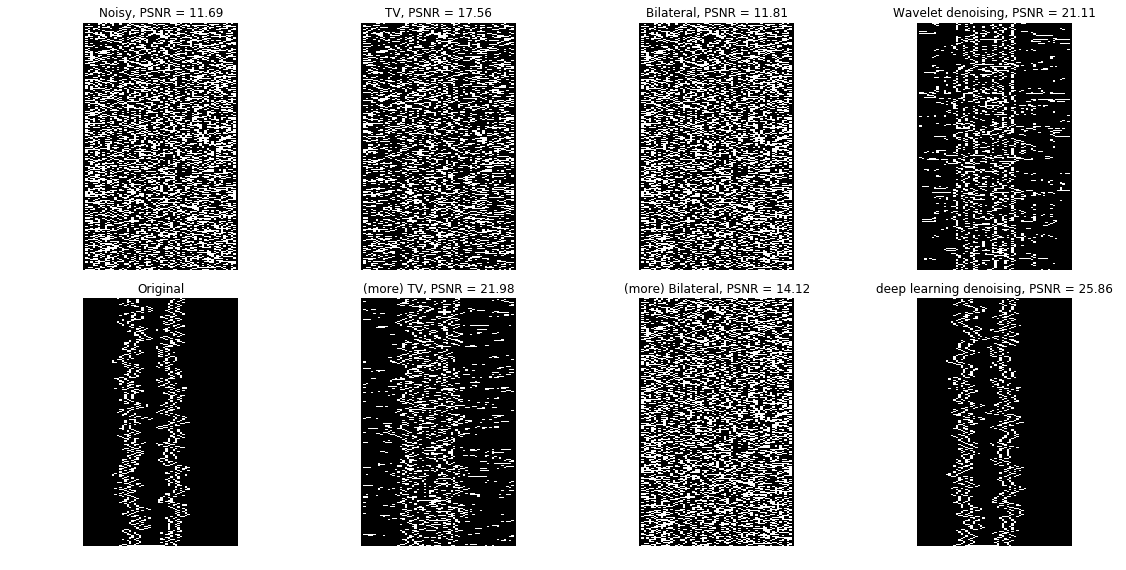

In [81]:
from scipy import ndimage as ndi
from skimage import feature


# Compute the Canny filter for two values of sigma
s = 1
edges_im = feature.canny(im, sigma = s)
edges_imnoisy = feature.canny(imnoisy, sigma = s)
edges_impredict = feature.canny(impredict, sigma = s)
edges_im_tv = feature.canny(im_denoise_tv_chambolle, sigma = s)
edges_im_moretv = feature.canny(im_denoise_moretv_chambolle, sigma = s)
edges_im_bilateral = feature.canny(im_denoise_bilateral, sigma = s)
edges_im_morebilateral = feature.canny(im_denoise_bilateral, sigma = s)
edges_im_wavelet = feature.canny(im_denoise_wavelet, sigma = s)

# display results
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8),
                                    sharex=True, sharey=True)

ax[0, 0].imshow(edges_imnoisy,cmap = 'gray',aspect= 0.1)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy, PSNR = {0:.4g}'.format(psnr_noisy))

ax[0, 1].imshow(edges_im_tv, cmap = 'gray',aspect= 0.1)
ax[0, 1].axis('off')
ax[0, 1].set_title('TV, PSNR = {0:.4g}'.format(psnr_tv))

ax[0, 2].imshow(edges_im_bilateral,cmap = 'gray',aspect= 0.1)
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral, PSNR = {0:.4g}'.format(psnr_bilateral))

ax[0, 3].imshow(edges_im_wavelet,cmap = 'gray',aspect= 0.1)
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising, PSNR = {0:.4g}'.format(psnr_wavelet))

ax[1, 1].imshow(edges_im_moretv,cmap = 'gray',aspect= 0.1)
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV, PSNR = {0:.4g}'.format(psnr_moretv))

ax[1, 2].imshow(edges_im_morebilateral,cmap = 'gray',aspect= 0.1)
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral, PSNR = {0:.4g}'.format(psnr_morebilateral))


ax[1, 3].imshow(edges_impredict,cmap = 'gray',aspect= 0.1)
ax[1, 3].axis('off')
ax[1, 3].set_title('deep learning denoising, PSNR = {0:.4g}'.format(psnr_predict))

ax[1, 0].imshow(edges_im,cmap = 'gray',aspect= 0.1)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

1.12100357597 1.08158518276 1.1758509574


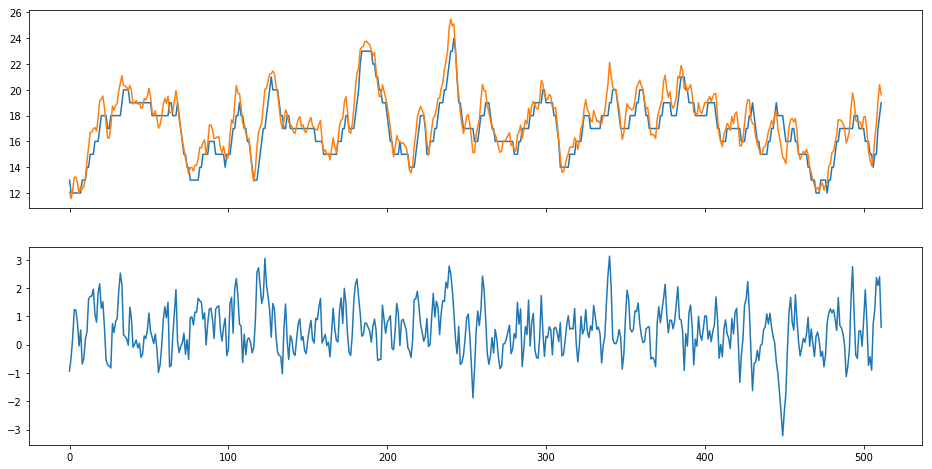

186
420.487553
527.489553


In [82]:
from skimage.filters import roberts, sobel, scharr

edge_sobel = sobel(im)

linescan_file = path + 'linescans\\linescan_' + "{:.2g}".format(sigma*1e-09) + '_' + str(alpha) + '_' + "{0:.2g}".format(Xi*1e-09) + '_' + str(width) + '_' + str(space) + '.txt'
linescan = []
with open(linescan_file,'r') as f:
    for line in f:
        a, b = line.split(',')
        linescan.append(float(b))


linescan = linescan[:2048]

leftline = np.array(linescan[:1024]) 
rightline = linescan[1024:]
rightline.reverse()
rightline = np.array(rightline)

leftline = leftline + shift
rightline = rightline + shift

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8),sharex=True, sharey=False)


ledge1 = np.argmax(edges_im, axis = 1)[256:768]
ledge2 = np.argmax(edges_impredict, axis = 1)[256:768]
print(np.std(ledge1)/2, np.std(ledge2)/2, np.std(leftline[256:768])/2)

#ax[0].plot(ledge1)
ax[0].plot(ledge2)
ax[0].plot(leftline[256:768])

ax[1].plot(leftline[256:768] - ledge2)
plt.show()

print(np.sum((ledge1 - ledge2)**2))
print(np.sum((leftline[256:768] - ledge1)**2))
print(np.sum((leftline[256:768] - ledge2)**2))

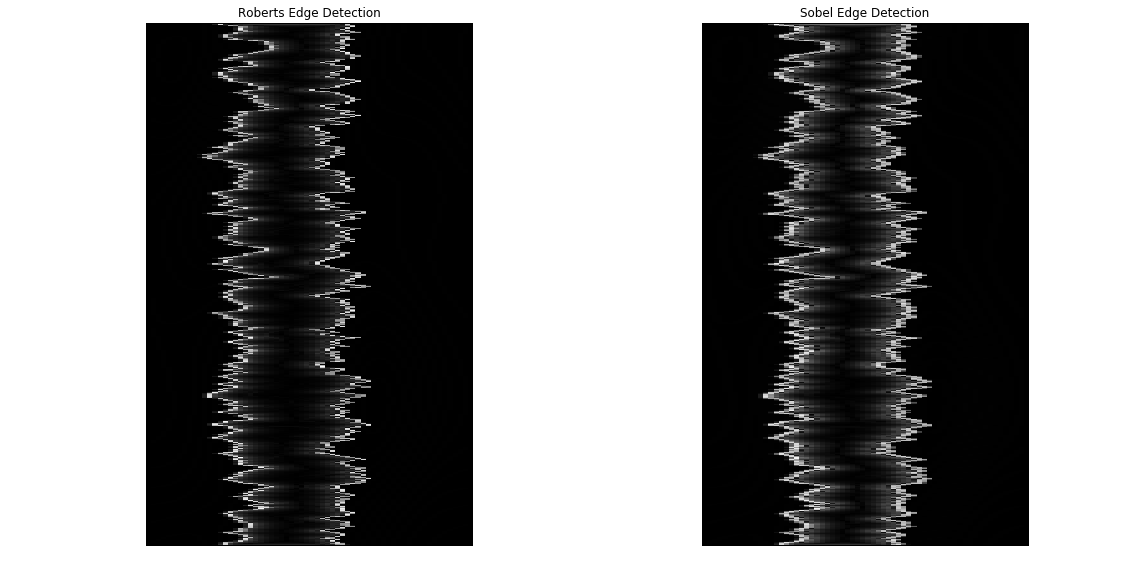

In [64]:
edge_roberts = roberts(im)
edge_sobel = sobel(im)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True,
                       figsize=(16, 8))

ax[0].imshow(edge_roberts, cmap=plt.cm.gray, aspect = 0.1)
ax[0].set_title('Roberts Edge Detection')

ax[1].imshow(edge_sobel, cmap=plt.cm.gray, aspect = 0.1)
ax[1].set_title('Sobel Edge Detection')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()